In [ ]:
!pip install ollama
!pip install datasets
!pip install pinecone-client
!pip install huggingface_hub
!pip install -U "huggingface_hub[cli]"
!pip install sentence-transformers

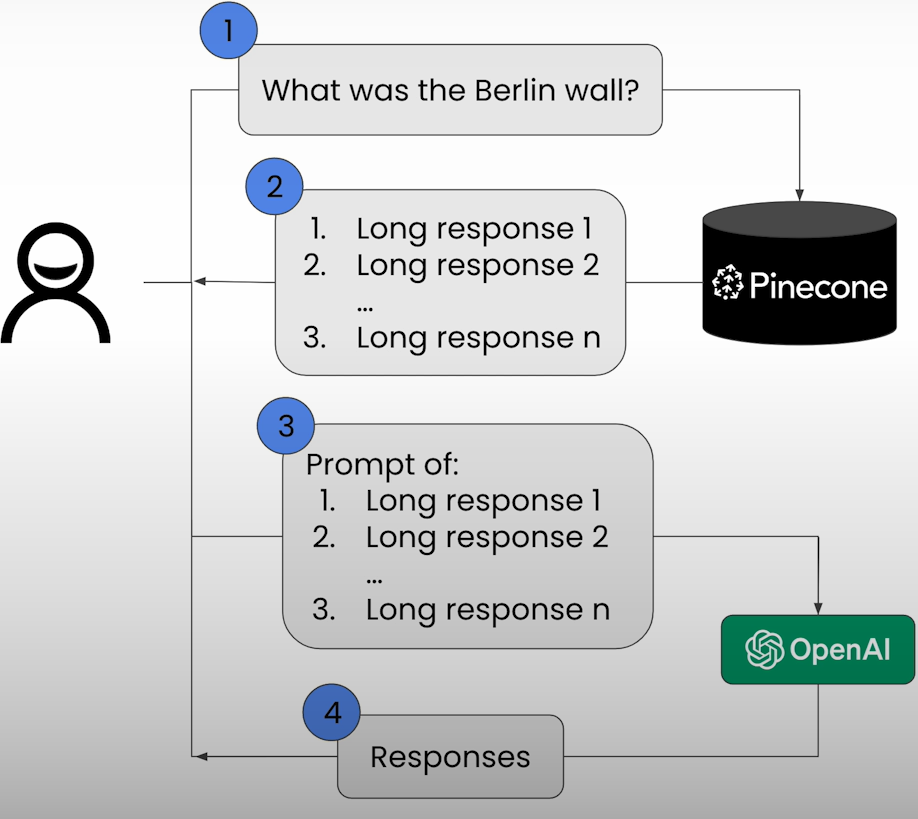

In [2]:
!wget -q -O lesson2-wiki.csv.zip "https://www.dropbox.com/scl/fi/yxzmsrv2sgl249zcspeqb/lesson2-wiki.csv.zip?rlkey=paehnoxjl3s5x53d1bedt4pmc&dl=0"
!unzip lesson2-wiki.csv.zip

Archive:  lesson2-wiki.csv.zip
  inflating: wiki.csv                


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# basics
import os
import ast
import torch
import pandas as pd
from tqdm.auto import tqdm

# API access
from google.colab import userdata

# Huggingface
import transformers
from huggingface_hub import login

# llm pipe
import ollama

# data & DB
from google.colab import userdata
from datasets import load_dataset
from pinecone import Pinecone, ServerlessSpec
from sentence_transformers import SentenceTransformer

In [5]:
# setup terminal
!pip install colab-xterm #https://pypi.org/project/colab-xterm/
%load_ext colabxterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 2.0 MB/s eta 0:00:00


In [ ]:
# open terminal
%xterm

# RUN
## curl -fsSL https://ollama.com/install.sh | sh
## ollama serve & ollama pull llama3.1 (or any other version)

In [7]:
dir(ollama)

['AsyncClient',
 'ChatResponse',
 'Client',
 'GenerateResponse',
 'Message',
 'Options',
 'ProgressResponse',
 'RequestError',
 'ResponseError',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_client',
 '_types',
 'chat',
 'copy',
 'create',
 'delete',
 'embed',
 'embeddings',
 'generate',
 'list',
 'ps',
 'pull',
 'push',
 'show']

In [8]:
%%time

# testing LLM using Ollama for response generation in RAG aaplication
# Pull the model first
ollama.pull('llama3.1')

response = ollama.chat(model='llama3.1', messages=[
  {
    'role': 'user',
    'content': 'Why is the sky blue?',
  },
])
print(response['message']['content'])

### Use this code for STREAMING chat responses ###

# response = ollama.chat(
#     model='llama3.1',
#     messages=[{'role': 'user', 'content': 'Why is the sky blue?'}],
#     stream=True)

# for chunk in response:
#   print(chunk['message']['content'], end='', flush=True)


The sky appears blue to us because of a phenomenon called Rayleigh scattering, named after the British physicist Lord Rayleigh who first described it in the late 19th century. Here's why:

**What happens:**

When sunlight enters Earth's atmosphere, it encounters tiny molecules of gases such as nitrogen (N2) and oxygen (O2). These molecules are much smaller than the wavelength of light. As a result, shorter wavelengths of light, like blue and violet, scatter more readily than longer wavelengths, like red and orange.

**The scattering process:**

When sunlight hits these gas molecules, it scatters in all directions, with the shorter wavelengths (blue and violet) being scattered more than the longer wavelengths (red and orange). This is because the smaller molecules are more effective at scattering the shorter wavelengths.

**Why we see blue:**

As a result of this scattering process, the sky appears blue to us. The blue light is scattered in all directions and reaches our eyes from every

### Setup Pinecone and Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device != "cuda":
    print("GPU not available")
else:
    print("GPU available\n\n")
    print()
model = SentenceTransformer("thenlper/gte-large", device=device)
print(model,'\n\n')

# access pinecone apikey
pinecone = Pinecone(api_key=userdata.get("PINECONE_API_KEY"))
INDEX_NAME = "rag-model-data-index"

# delete existing index, if exists
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
    print(f"Index {INDEX_NAME} already exists")
    pinecone.delete_index(INDEX_NAME)
    print(f"Index {INDEX_NAME} deleted")
else:
    print(f"Index {INDEX_NAME} does not exist")


In [10]:
# Create a new index with the specified name, dimension, and metric
pinecone.create_index(
    name=INDEX_NAME,
    dimension=model.get_sentence_embedding_dimension(),  # model enbedding dimensions
    metric="cosine",  # search metric
    spec=ServerlessSpec(cloud="aws", region="us-east-1")
)

index = pinecone.Index(INDEX_NAME)
print('Index rag-model-data-index created\n')
print(f'Embedding Dimension: {model.get_sentence_embedding_dimension()}\n')
print(index)

Index rag-model-data-index created

Embedding Dimension: 1024



In [11]:
# the more articles the LLM can see the better it will get
max_articles_num = 2000
# load to dataframe
df = pd.read_csv('/content/wiki.csv', nrows=max_articles_num)
# view first 5
df.head()

,id,metadata,values
1,1-0,"{'chunk': 0, 'source': 'https://simple.wikiped...","[-0.011254455894231796, -0.01698738895356655, ..."
2,1-1,"{'chunk': 1, 'source': 'https://simple.wikiped...","[-0.0015197008615359664, -0.007858820259571075..."
3,1-2,"{'chunk': 2, 'source': 'https://simple.wikiped...","[-0.009930099360644817, -0.012211072258651257,..."
4,1-3,"{'chunk': 3, 'source': 'https://simple.wikiped...","[-0.011600767262279987, -0.012608098797500134,..."
5,1-4,"{'chunk': 4, 'source': 'https://simple.wikiped...","[-0.026462381705641747, -0.016362832859158516,..."


### Prepare embeddings and upsert to Pinecone

In [12]:
# convert the metadata string to dict using ast
df['metadata'] = df['metadata'].apply(lambda x: ast.literal_eval(x))
df['metadata'].head(2)

1    {'chunk': 0, 'source': 'https://simple.wikiped...
2    {'chunk': 1, 'source': 'https://simple.wikiped...
Name: metadata, dtype: object

In [13]:
# preprocessing for vector dimension as index is 1024
def adjust_vector_dimension(vector, target_dim):
    current_dim = len(vector)
    if current_dim > target_dim:
        return vector[:target_dim]  # Truncate if longer
    elif current_dim < target_dim:
        return vector + [0] * (target_dim - current_dim)  # Pad with zeros if shorter
    return vector

In [ ]:
TARGET_DIMENSION = 1024  # Change this if your target dimension is different

prepped = []

for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    values = ast.literal_eval(row['values'])
    values = adjust_vector_dimension(values, TARGET_DIMENSION)

    prepped.append({
        'id': row['id'],
        'values': values,  # Ensure values have the correct dimension
        'metadata': row['metadata']  # 'metadata' is already a dict
    })

    if len(prepped) >= 250:
        index.upsert(prepped)
        prepped = []

In [15]:
index.describe_index_stats()

{'dimension': 1024,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 2000}},
 'total_vector_count': 2000}

### Connect to Huggingface Embedding Model

In [16]:
def get_embeddings(articles, model=model):
   return model.encode(articles)

### Run Query

In [17]:
%%time

query = "what is the berlin wall?"

embed = get_embeddings([query])
embed_list = embed[0].tolist()

result = index.query(vector=embed_list,
                     top_k=3,
                     include_metadata=True
                     )

text = [r['metadata']['text'] for r in result['matches']]
print('\n'.join(text))

Saturn's clouds show a banded pattern, like the cloud bands seen on Jupiter. Saturn's clouds are much fainter and the bands are wider at the equator. Saturn's lowest cloud layer is made up of water ice, and is about  thick. The temperature here is quite low, at 250 K (-10°F, -23°C). However scientists do not agree about this. The layer above, about  thick, is made up of ammonium hydrosulfide ice, and above that is a layer of ammonia ice clouds  thick. The highest layer is made up of hydrogen and helium gases, which extends between  and  above the water cloud tops. Auroras are also known to form in Saturn in the mesosphere. The temperature at Saturn's cloud tops is extremely low, at 98 K (-283 °F, -175 °C). The temperatures in the inner layers are much higher than the outside layers because of the heat produced by Saturn's interior.
Saturn's winds are some of the fastest in the Solar System, reaching 1,800 km/h (1,118 mph), ten times faster than winds on Earth.

Storms and spots 
Saturn

### Building Prompt for LLM

In [18]:
query = "write an article titled: what is the berlin wall?"

# Generate embeddings for the query
embed = get_embeddings([query])
embed_list = embed[0].tolist()

# Send the query to Pinecone
result = index.query(vector=embed_list,
                     top_k=3,
                     include_metadata=True
                     )

# Extract contexts from the query results
contexts = [
    x['metadata']['text'] for x in result['matches']
]

# Create the prompt for the Ollama model
prompt_start = (
    "Answer the question based on the context below.\n\n"+
    "Context:\n"
)

prompt_end = (
    f"\n\nQuestion: {query}\nAnswer:"
)

prompt = (
    prompt_start + "\n\n---\n\n".join(contexts) +
    prompt_end
)

### Get LLM Response

In [19]:
%%time
# Send the prompt to Ollama's chat API
response = ollama.chat(model='llama3.1', messages=[
    {
        'role': 'system',
        'content': 'You are an assistant that will help in providing clear and concise responses.'
    },
    {
        'role': 'user',
        'content': prompt
    }
])

# Print the response content
print(response['message']['content'])

However, I don't see a question related to the Berlin Wall in the context you provided. The text appears to be about the bubonic plague and its different forms, as well as a discussion on mammals.

If you'd like, I can write an article on the Berlin Wall based on general knowledge. However, please note that it's not directly related to the context you provided.

Here's the article:

**What is the Berlin Wall?**

The Berlin Wall was a physical barrier that divided East and West Berlin during the Cold War era. It was erected in 1961 by the government of the German Democratic Republic (GDR, or East Germany) to prevent East Germans from fleeing to the West.

The wall was built on August 13, 1961, and it effectively cut off West Berlin from the rest of East Germany, creating a physical and psychological barrier between the two cities. The wall was patrolled by guards who were authorized to shoot anyone attempting to cross into the Western sector.

The construction of the Berlin Wall was a r